In [1]:
# Import Modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
# Import dataset, confirmed cases time series
origdf = pd.read_csv("confirmed_diff.csv")
df = origdf.copy()
df.dropna()
df = df[['region', 'Value', 'Province_State']]

In [3]:
# df['Province_State'].unique()

array(['South Carolina', 'Louisiana', 'Virginia', 'Idaho', 'Iowa',
       'Kentucky', 'Missouri', 'Oklahoma', 'Colorado', 'Illinois',
       'Indiana', 'Mississippi', 'Nebraska', 'North Dakota', 'Ohio',
       'Pennsylvania', 'Washington', 'Wisconsin', 'Vermont', 'Minnesota',
       'Florida', 'North Carolina', 'California', 'New York', 'Wyoming',
       'Michigan', 'Alaska', 'Maryland', 'Kansas', 'Tennessee', 'Texas',
       'Maine', 'Arizona', 'Georgia', 'Arkansas', 'New Jersey',
       'South Dakota', 'Alabama', 'Oregon', 'West Virginia',
       'Massachusetts', 'Utah', 'Montana', 'New Hampshire', 'New Mexico',
       'Rhode Island', 'Nevada', 'District of Columbia', 'Connecticut',
       'Hawaii', 'Delaware', 'Diamond Princess', 'Grand Princess', 'Guam',
       'Puerto Rico', 'Virgin Islands', 'Northern Mariana Islands',
       'American Samoa'], dtype=object)

In [4]:
# Offset for prediction, default 10 for predicting a particular date by its previous 10 days confirmed cases
OFFSET = 10

# All regions in the dataset
regions = df['region'].unique()

# Construct for the region dictionary & region encoding
region_dict = {regions[x]:x for x in range(len(regions))}

# Training States subset
subset = ["South Carolina", "California", 
          "North Carolina", "New York", 
          "New Jersey", "Georgia", 
          "Ohio", "Florida", 
          "Massachusetts", "Washington"]

# Testing States subset
test_region = ['Illinois', 'Texas', 'Nevada']

# Train and Test subset
# df['region_encode'] = df.apply(lambda x: region_dict[x['region']], axis=1)
traindf = df[df['Province_State'].isin(subset)]
testdf = df[df['Province_State'].isin(test_region)]

# Organizes data and automatically creates past 10 days data
def organize_data(x, days_offset=10):
    # Unused
    x['id'] = range(len(x)) 
    # Standardize x-value
    x['norm-0'] = (x['Value'] - x['Value'].mean()) / x['Value'].std()
    # Create columns for past days
    for item in range(days_offset):
        x['norm-%s'%str(item+1)] = x.shift(periods=(1+item))['norm-0']
    # And truncate the NAs
    out = x[days_offset:]
    return out

In [5]:
# Normalizes training dataset and create past 10 days data
tr_df = traindf.groupby('region').apply(organize_data)
# encodes the regions
tr_df['region_encode'] = tr_df.apply(lambda x: region_dict[x['region']], axis=1)

# Normalizes testing dataset and create past 10 days data
te_df = testdf.groupby("region").apply(organize_data)
# encodes the regions
te_df['region_encode'] = te_df.apply(lambda x: region_dict[x['region']], axis=1)

In [6]:
# drops the hierarchical indexes
tr_df.index = tr_df.index.droplevel()
te_df.index = te_df.index.droplevel()

In [7]:
# drops miscellaneous values
tr_df.pop("Value")
tr_df.pop("id")
tr_df.pop("region")
tr_df.pop("Province_State")
# --------
te_df.pop("Value")
te_df.pop("id")
te_df.pop("region")
te_df.pop("Province_State")
# Prevents jupyter from printing out the te_df['Province_State']
print("")

1025      Illinois
1026      Illinois
1027      Illinois
1028      Illinois
1029      Illinois
            ...   
331801       Texas
331802       Texas
331803       Texas
331804       Texas
331805       Texas
Name: Province_State, Length: 36763, dtype: object

In [8]:
# Training and Testing targets
train_labels = tr_df.pop('norm-0')
test_labels = te_df.pop("norm-0")

In [9]:
# Model Build functions
def build_model(train_dataset):
    # 2 hidden layers, 128 units, activation functions specified as relu
    # and 1 final layer for prediction result
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=[len(train_dataset.keys())]),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss="mse",
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

# Compile model
model = build_model(tr_df)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
# Summary for the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 17,537
Trainable params: 17,537
Non-trainable params: 0
_________________________________________________________________


In [11]:
# output for untrained model
ex_b = tr_df[tr_df['region_encode'] == region_dict['Wilson - North Carolina']][-10:]
ex_res = model.predict(ex_b)
ex_res

array([[-750.4825 ],
       [-750.4823 ],
       [-750.40967],
       [-750.4371 ],
       [-750.3967 ],
       [-750.3949 ],
       [-750.35645],
       [-750.3525 ],
       [-750.3459 ],
       [-750.34546]], dtype=float32)

In [12]:
# Prints the progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print("")
        print(".", end="")

# Max iterations = 500
EPOCHS = 500

# Full Model Training
# history = model.fit(tr_df, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()])
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Basic': history}, metric = "mean_absolute_error")
# plt.ylim([0, 1])
# plt.ylabel('MAE [MPG]')


...........................

Text(0, 0.5, 'MAE [MPG]')

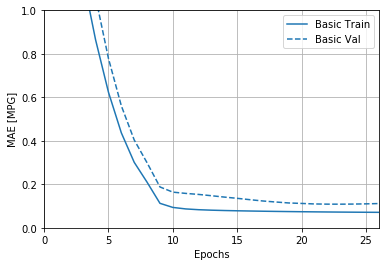

In [13]:
# Reduced model training, stops when the model appears it cannot be further improved
model = build_model(tr_df)

# criteria for stopping, patience set to 15
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

# train the model
history=model.fit(tr_df, train_labels, epochs=EPOCHS,
                 validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

# Plots the training result
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mean_absolute_error")
plt.ylim([0, 1])
plt.ylabel('MAE [MPG]')

In [14]:
# Evaluate the model for test dataset
loss, mae, mse = model.evaluate(te_df, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

36763/36763 - 0s - loss: 0.0517 - mean_absolute_error: 0.1093 - mean_squared_error: 0.0517
Testing set Mean Abs Error:  0.11 MPG


In [15]:
# Integrate the predicted values and actual values to a new dataset
integrated_te_df = te_df.copy()
integrated_te_df['norm-0'] = test_labels
test_predictions = model.predict(te_df).flatten()
integrated_te_df['norm-0-pred'] = test_predictions

In [ ]:
# And plot the predicted vs. actual
# for x in integrated_te_df['region_encode'].unique()[:10]:
#     subset = integrated_te_df[integrated_te_df['region_encode'] == x]
#     plt.scatter(subset['norm-0'], subset['norm-0-pred'])
#     plt.xlabel('True Values [MPG]')
#     plt.ylabel('Predictions [MPG]')
#     plt.axis('equal')
#     plt.axis('square')
#     plt.xlim([0,plt.xlim()[1]])
#     plt.ylim([0,plt.ylim()[1]])
#     plt.plot([-100, 100], [-100, 100])
#     plt.show()

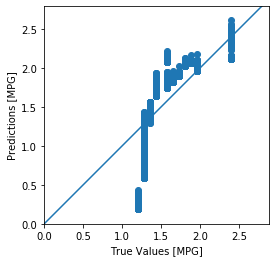

In [16]:
# Plot for all of the regions' predicted vs. actual
# Kind of problematic when true values between 1.0~1.5 and above 2.5
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])

Text(0, 0.5, 'Count')

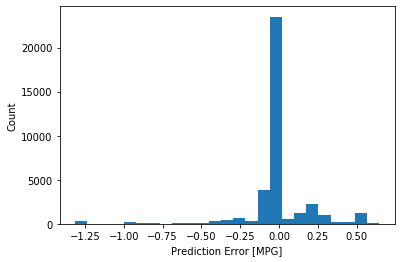

In [17]:
# Plots the residuals, shows some kind of normality and centering at zero
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")

In [18]:
# The unique values of "Date"
# origdf['Date'].unique()

array(['1/22/2020', '1/23/2020', '1/24/2020', '1/25/2020', '1/26/2020',
       '1/27/2020', '1/28/2020', '1/29/2020', '1/30/2020', '1/31/2020',
       '2/1/2020', '2/2/2020', '2/3/2020', '2/4/2020', '2/5/2020',
       '2/6/2020', '2/7/2020', '2/8/2020', '2/9/2020', '2/10/2020',
       '2/11/2020', '2/12/2020', '2/13/2020', '2/14/2020', '2/15/2020',
       '2/16/2020', '2/17/2020', '2/18/2020', '2/19/2020', '2/20/2020',
       '2/21/2020', '2/22/2020', '2/23/2020', '2/24/2020', '2/25/2020',
       '2/26/2020', '2/27/2020', '2/28/2020', '2/29/2020', '3/1/2020',
       '3/2/2020', '3/3/2020', '3/4/2020', '3/5/2020', '3/6/2020',
       '3/7/2020', '3/8/2020', '3/9/2020', '3/10/2020', '3/11/2020',
       '3/12/2020', '3/13/2020', '3/14/2020', '3/15/2020', '3/16/2020',
       '3/17/2020', '3/18/2020', '3/19/2020', '3/20/2020', '3/21/2020',
       '3/22/2020', '3/23/2020', '3/24/2020', '3/25/2020', '3/26/2020',
       '3/27/2020', '3/28/2020', '3/29/2020', '3/30/2020', '3/31/2020',
       '4/

In [19]:
# Create new dataframe for predicting 5/3/2020 confirmed cases
preddf = origdf.copy()[['Date', "region", 'Value']]

# Computes the region mean and standard deviation, useful for un-doing the normalization
region_mean = {region_dict[regions[x]]:preddf[preddf['region'] == regions[x]].mean().Value 
               for x in range(len(regions))}
region_std = {region_dict[regions[x]]:preddf[preddf['region'] == regions[x]].std().Value 
              for x in range(len(regions))}


In [20]:
# aggregate data for prediction
preddf = preddf.groupby("region").apply(organize_data)
preddf.index = preddf.index.droplevel()

In [22]:
# Organize the dataframe to remove unnecessary columns
lastday = preddf[preddf['Date'] == "5/2/2020"]
lastdaydt = lastday.copy()
lastdaydt['region_encode'] = lastdaydt.apply(lambda x: region_dict[x['region']], axis=1)
lastdaydt.pop("Date")
lastdaydt.pop("region")
lastdaydt.pop("Value")
lastdaydt.pop("id")
lastdaydt.pop("norm-5")

101       2.720593
203       2.720593
305       2.720593
407       2.720593
509       2.720593
            ...   
331499    2.720593
331601    2.720593
331703    2.720593
331805    2.720593
331907    2.720593
Name: norm-5, Length: 3254, dtype: float64

In [23]:
# Make Predictions
pred53 = model.predict(lastdaydt)

In [27]:
# Attach the prediction result to the original dataframe
lastday['5-3-pred'] = pred53

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,region,Value,id,norm-0,norm-1,norm-2,norm-3,norm-4,norm-5,5-3-pred
101,5/2/2020,Abbeville - South Carolina,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.879297
203,5/2/2020,Acadia - Louisiana,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.890303
305,5/2/2020,Accomack - Virginia,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.896085
407,5/2/2020,Ada - Idaho,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.901196
509,5/2/2020,Adair - Iowa,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.909969
611,5/2/2020,Adair - Kentucky,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.919402
713,5/2/2020,Adair - Missouri,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.929389
815,5/2/2020,Adair - Oklahoma,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.938748
917,5/2/2020,Adams - Colorado,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.943569
1019,5/2/2020,Adams - Idaho,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.940984


In [32]:
# un-do normalization
def orig(x):
    reg = region_dict[x['region']]
    std = region_std[reg]
    mn = region_mean[reg]
    predval = x['5-3-pred']
    return predval * std + mn

# Apply them to every prediction values
lastday['5-3-predict'] = lastday.apply(orig, axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Date,region,Value,id,norm-0,norm-1,norm-2,norm-3,norm-4,norm-5,5-3-pred,5-3-predict
101,5/2/2020,Abbeville - South Carolina,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.879297,30.394875
203,5/2/2020,Acadia - Louisiana,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.890303,177.795018
305,5/2/2020,Accomack - Virginia,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.896085,218.247759
407,5/2/2020,Ada - Idaho,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.901196,920.299811
509,5/2/2020,Adair - Iowa,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.909969,1.906106
611,5/2/2020,Adair - Kentucky,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.919402,88.703443
713,5/2/2020,Adair - Missouri,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.929389,18.674365
815,5/2/2020,Adair - Oklahoma,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.938748,69.984346
917,5/2/2020,Adams - Colorado,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.943569,1656.791574
1019,5/2/2020,Adams - Idaho,31,101,2.948146,2.948146,2.948146,2.720593,2.720593,2.720593,2.940984,3.426468


In [42]:
# Predict for state California 
CALregion = origdf[origdf['Province_State'] == 'California']['region'].unique()
CALPredict = lastday[lastday['region'].isin(CALregion)]
CALPredict['5-3-predict'].sum()

54929.12489818006

In [44]:
# Helper functions for getting the predicted result
# Can get the entire US' prediction, or prediction by state, or prediction by county
def get_predict(reg):
    if reg == "ALL":
        return lastday['5-3-predict'].sum()
    if not "-" in reg:
        state = origdf[origdf['Province_State'] == reg]['region'].unique()
        pred = lastday[lastday['region'].isin(state)]
        return pred['5-3-predict'].sum()
    else:
        county = lastday[lastday['region'] == reg] 
        return county['5-3-predict']

In [45]:
# Gets the prediction for all counties in North Carolina
get_predict("North Carolina")

11538.09451651189

In [46]:
# Gets the prediction for all states in US
get_predict("ALL")

1234365.8594393197